In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# supress warning messages

import warnings
warnings.filterwarnings('ignore')

<h2>Human Activity Recognition Using Accelerometers and Gyroscopes</h2>

Experimental 'human activity' data generated by 30 voluteers between the ages of 19-48 performing one of 6 standard activities (1-WALKING, 2-WALKING_UPSTAIRS, 3=WALKING_DOWNSTAIRS, 4-SITTING, 5-STANDING, 6-LAYING). Each volunteer wore a waist-mounted smartphone (Samsung Galaxy S II) with an embedded accelerometer and gyroscope that captured 3-axial linear acceleration and 3-axial angular velocity measures at a constant rate of 50Hz (i.e. 50 data points per second). The volunteers were video-recorded during their performances. The recordings were used to label the activities manually.

Together the recordings and labeling process resulted in a dataset containing 7352 rows

In this particular analysis (one of 2 using the 2012 UCI HAR database), the dataset was randomly partitioned into 2 sets --  one containing 70% of the cases used for training and another containing 30% to be used for testing. Each set contains 561 features derived from the linear acceleration and angular velocity measures along with the activity associated with the specific measures. The goal is to see whether a machine learning model can be used to predict (recognize) what a person is doing based on the measurements produced by the smartphone. In this case there is only one machine model of interest - Random Forest Classification.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline

In [5]:
# combining features and activities into a single dataframe

features = pd.read_csv('data/features.txt',sep='|', header=None)
activities = pd.read_csv('data/activities.txt',sep='|', header=None)
activities.columns = ['activity']
data = pd.concat([activities, features], axis=1)

print(data.shape)
data.sample(5)

(7352, 562)


,activity,0,1,2,3,4,5,6,7,8,...,551,552,553,554,555,556,557,558,559,560
5267,2,0.266077,-0.022756,-0.114406,-0.474733,-0.335234,-0.420207,-0.535222,-0.389291,-0.376794,...,-0.298070,0.044586,-0.376011,0.338137,-0.043792,0.810153,0.946567,-0.733273,0.226418,-0.118934
5431,3,0.194271,-0.014772,-0.133141,-0.254231,0.007914,-0.531082,-0.326622,-0.025476,-0.523574,...,-0.049267,0.023679,-0.357487,0.798177,0.037080,0.855738,-0.822875,-0.864216,0.154196,-0.061276
2603,6,0.271017,-0.016169,-0.105228,-0.984479,-0.978497,-0.965314,-0.991167,-0.981600,-0.973454,...,-0.184940,-0.056341,-0.488093,-0.237885,0.468426,-0.225326,0.255934,0.439181,-0.701868,-0.275076
5496,5,0.277953,-0.030307,-0.118133,-0.996627,-0.977220,-0.987927,-0.997193,-0.975919,-0.987969,...,0.196746,-0.462218,-0.773721,-0.024683,-0.079700,0.029970,-0.464799,-0.861407,0.160425,-0.058574
1352,4,0.278249,-0.013310,-0.110130,-0.998150,-0.990400,-0.990289,-0.998270,-0.989489,-0.989531,...,0.152926,-0.387069,-0.734779,-0.049473,-0.207255,0.134002,-0.309462,-0.979943,0.084062,0.028356


In [6]:
# activity (row) counts: (1-WALKING, 2-WALKING_UPSTAIRS, 3=WALKING_DOWNSTAIRS, 4-SITTING, 5-STANDING, 6-LAYING)
data.activity.value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: activity, dtype: int64

In [7]:
# row (observation) counts per subject - subjects are not part of the analysis per se

subjects = pd.read_csv('data/subjects.txt',sep='|', header=None)
subjects.iloc[:,0].value_counts()

25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
Name: 0, dtype: int64

In [8]:
# randomly distribute 70% of rows into training set and the remaining 30% in testing set
train = data.sample(frac=0.7,
                    random_state=42)

test = data[~data.index.isin(train.index)]

print(train.shape)
print(test.shape)

(5146, 562)
(2206, 562)


In [9]:
# 'independent features' X
X = train.iloc[:,1:562]

print(X.shape)
X.sample(5)

(5146, 561)


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
3011,0.329740,-0.019646,-0.104104,0.094112,-0.016128,0.157917,0.057296,-0.084757,0.118268,0.419559,...,0.196456,-0.310587,-0.742963,-0.745801,-0.922608,0.808032,-0.014476,-0.670665,0.228389,0.210367
4814,0.187920,-0.022493,-0.114320,-0.285203,-0.001438,0.163397,-0.339592,-0.134192,0.172202,0.093298,...,0.278589,-0.381085,-0.806618,0.765867,-0.099255,0.815948,0.007978,-0.796053,0.199388,0.119815
2715,0.275522,-0.017182,-0.106995,-0.997883,-0.985124,-0.988070,-0.998309,-0.984525,-0.988419,-0.942024,...,0.334418,-0.383051,-0.744821,0.488801,0.299624,0.432491,-0.835726,-0.897946,0.168424,0.010507
6767,0.209149,0.007983,-0.059764,0.213444,-0.269561,-0.218734,0.131383,-0.333641,-0.203771,0.575052,...,0.196454,0.580750,0.448830,0.348332,0.143166,0.940197,0.559357,-0.860000,0.139543,-0.074247
4680,0.191800,-0.094544,-0.070338,-0.006563,0.244896,-0.042076,-0.080621,0.199612,-0.015872,0.244879,...,0.200718,-0.164752,-0.587242,0.107947,-0.193804,-0.973398,-0.413042,-0.668125,0.296802,0.134031


In [10]:
# 'dependent variable' Y

Y = train.activity
print(Y.shape)

(5146,)


In [11]:
randomState = 42
ntree = 25

model0 = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=True,
             oob_score=True)
model0 = model0.fit(X, Y)
model0.oob_score_

0.9646327244461718

In [12]:
def varPlot(X,model,plotSize=(15,6),xticks=False, ntree=10, nvars = 25):
    
    model_vars = pd.DataFrame({'variable':X.columns,
                               'importance':model.feature_importances_})
    
    #model_vars.sort_values(by='importance', ascending=False,inplace=True).reset_index()
    model_plot_data = model_vars.sort_values(by='importance', ascending=False).reset_index()
    
    varImp = plt.figure(figsize=plotSize)
    
    varImp = sns.barplot(y='importance', x='variable', data=model_plot_data.iloc[:nvars,0:],
        palette=sns.color_palette("Blues_r",n_colors=X.shape[1]))
    
    if xticks==True:
        varImp = plt.xticks([])
    else:
        varImp = plt.xticks(rotation=90)
        
    varImp = plt.xlabel('Variable')
    varImp = plt.ylabel('Variable Importance')
    varImp = plt.title('Random Forest : Averaged variable importance over '+str(ntree)+' trees')
    
    return(varImp)

Text(0.5, 1.0, 'Random Forest : Averaged variable importance over 10 trees')

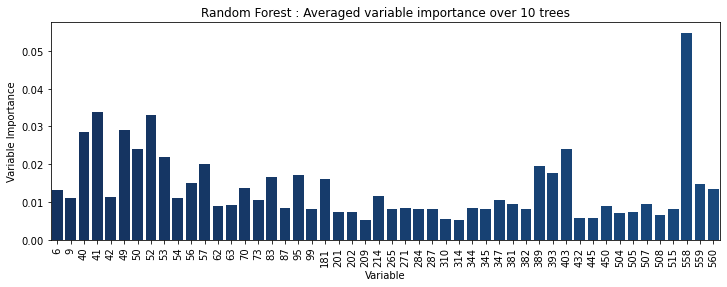

In [13]:
varPlot(X=X,model=model0,plotSize=(12,4),xticks=False,nvars=50)

In [14]:
model_vars0 = pd.DataFrame( {'variable':X.columns,'importance':model0.feature_importances_})
model_vars0.sort_values(by='importance', ascending=False, inplace=True)

In [15]:
n = 25

cols_model = [col for col in model_vars0.variable[:n].values]

In [16]:
oobAccuracy = {}

for cols in range(n):
    X = train[[col for col in model_vars0['variable'][:cols+1].values]]
    #Y = train.activity
    
    model1 = rfc(n_estimators=ntree,
                 random_state=randomState,
                 n_jobs=4,
                 warm_start=False,
                 oob_score=True)
    
    model1 = model1.fit(X, Y)
    accuracy = accuracy_score(Y,model1.predict(X))
    
    oobAccuracy[cols+1] = [cols+1,model1.oob_score_,accuracy]

accuracyTable =pd.DataFrame.from_dict(oobAccuracy).transpose()
accuracyTable.columns = ['variables','oobAccuracy','accuracy']

<Figure size 720x360 with 0 Axes>

(0.0, 26.0)

(0.0, 100.0)

Text(0.5, 0, 'Number of variables')

Text(0, 0.5, 'Accuracy(%)')

Text(0.5, 1.0, 'OOB Accuracy vs Number of variables')

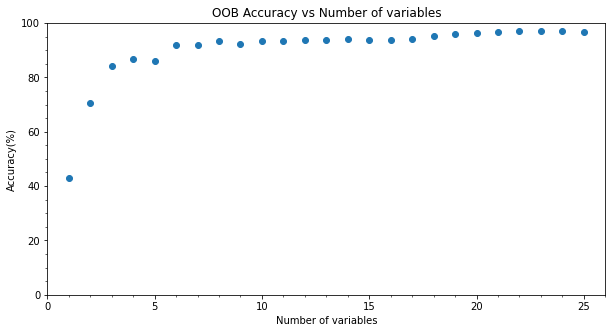

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(x=accuracyTable.variables,
                y=100*accuracyTable.oobAccuracy)

plt.xlim(0,n+1)
plt.ylim(0,100)
plt.minorticks_on()

plt.xlabel('Number of variables')
plt.ylabel('Accuracy(%)')
plt.title('OOB Accuracy vs Number of variables')

Text(0.5, 1.0, 'Random Forest : Averaged variable importance over 10 trees')

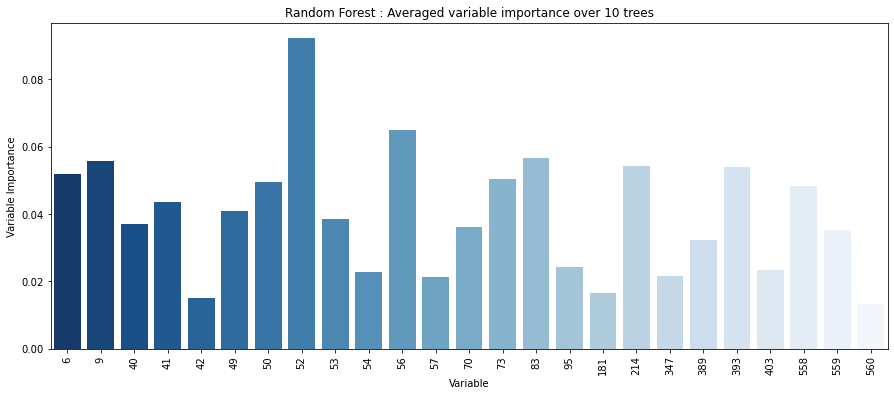

In [18]:
varPlot(X,model1)

In [19]:
n_used = 4

cols_model = [col for col in model_vars0.variable[:n_used].values] + [model_vars0.variable[6]]

In [20]:
cols_model

[558, 41, 52, 49, 6]

In [21]:
X = train[cols_model]

In [22]:
ntree_determination = {}

for ntree in range(5,150,5):
    model = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=False,
             oob_score=True)
    model = model.fit(X, Y)
    ntree_determination[ntree]=model.oob_score_

In [23]:
ntree_determination = pd.DataFrame.from_dict(ntree_determination,orient='index')
ntree_determination['ntree'] = ntree_determination.index
ntree_determination.columns=['oobScore','ntree']

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Number of trees used')

Text(0, 0.5, 'OOB Accuracy')

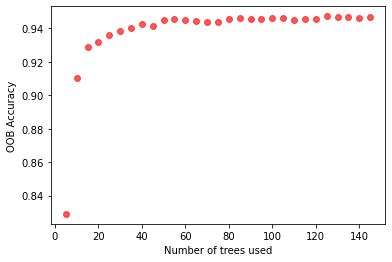

In [24]:
plt.figure(figsize=(6,4),)
plt.scatter(x='ntree',
                y='oobScore',
                s=35,c='red',alpha=0.65,
                data=ntree_determination)
plt.xlabel('Number of trees used')
plt.ylabel('OOB Accuracy')

In [25]:
model2 = rfc(n_estimators=50,
             random_state=randomState,
             n_jobs=4,
             warm_start=False,
             oob_score=True)
model2 = model2.fit(X, Y)

Text(0.5, 1.0, 'Random Forest : Averaged variable importance over 10 trees')

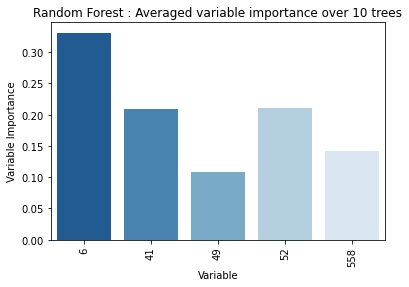

In [26]:
varPlot(X,model2,plotSize=(6,4))

In [27]:
train_actual = Y
train_pred = model2.predict(X)

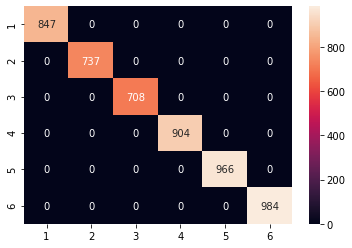

In [28]:
cm= confusion_matrix(train_actual,train_pred)
sns.heatmap(data=cm,
            fmt='.0f',
            annot=True,
            xticklabels=np.unique(train_actual),
            yticklabels=np.unique(train_actual))

In [29]:
accuracy_score(train_actual,train_pred)

1.0

In [30]:
model2.oob_score_

0.9448115040808395

In [31]:
test_actual = test.iloc[:,0]
test_pred = model2.predict(test[X.columns])

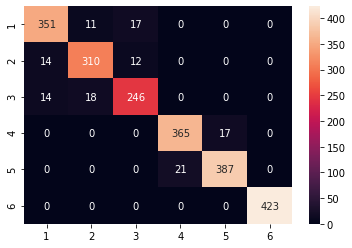

In [32]:
cm = confusion_matrix(test_actual,test_pred)
sns.heatmap(data=cm,
            fmt='.0f',
            annot=True,
            xticklabels=np.unique(test_actual),
            yticklabels=np.unique(test_actual))

In [33]:
accuracy_score(test_actual,test_pred)

0.9437896645512239